In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [11]:
import matplotlib.pyplot as plt
from matplotlib import dates
import xarray as xr
import pandas as pd
import os, glob
import six
from stompy import xr_utils
from stompy.plot import plot_wkb
from stompy import utils
from matplotlib import gridspec
from shapely import wkt

import seaborn as sns
import numpy as np
%matplotlib notebook

In [12]:
from stompy.grid import unstructured_grid
import stompy.model.delft.dflow_model as dfm

In [13]:
import bloom_common

In [17]:
roto_dir="rotodfm_v05"

In [14]:
model=dfm.DFlowModel.load(os.path.join(roto_dir,"blob_20220804T1812_20220830T1759_v00/"))

In [18]:
map_ds=model.map_dataset()

In [20]:
map_ds.dss[0]

<xarray.Dataset>
Dimensions:                      (nmesh2d_EnclosurePoints: 689,
                                  nmesh2d_EnclosureInstance: 1,
                                  nmesh2d_EnclosureParts: 1, nNetNode: 2883,
                                  nNetLink: 6354, nNetLinkPts: 2,
                                  nNetElem: 3472, nNetElemMaxNode: 6,
                                  nNetLinkContourPts: 4, nBndLink: 713,
                                  nFlowElem: 3472, nFlowElemContourPts: 6,
                                  nFlowLink: 5642, nFlowLinkPts: 2, time: 2497,
                                  laydim: 16, wdim: 17)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.809e+05 ... 5.816e+05
    NetNode_y                    (nNetNode) float64 4.151e+06 ... 4.153e+06
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
  * time                         (time) datetime64[ns] 2022-08-04T18:12:00 .....
    LayCoord_cc                  (laydim) float64 ...
Dimensions without coordinates: nmesh2d_EnclosurePoints,
                                nmesh2d_EnclosureInstance,
                                nmesh2d_EnclosureParts, nNetNode, nNetLink,
                                nNetLinkPts, nNetElem, nNetElemMaxNode,
                                nNetLinkContourPts, nBndLink, nFlowElem,
                                nFlowElemContourPts, nFlowLink, nFlowLinkPts,
                                laydim, wdim
Data variables: (12/47)
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    ...                           ...
    sa1                          (time, nFlowElem, laydim) float64 ...
    tem1                         (time, nFlowElem, laydim) float64 ...
    oakland0                     (time, nFlowElem, laydim) float64 ...
    eastshore0                   (time, nFlowElem, laydim) float64 ...
    oakland1                     (time, nFlowElem, laydim) float64 ...
    eastshore1                   (time, nFlowElem, laydim) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.143.141645M, Mar 20 2023,...
    history:        Created on 2023-04-15T05:15:48-0700, D-Flow FM
    date_created:   2023-04-15T05:15:48-0700
    date_modified:  2023-04-15T05:15:48-0700
    Conventions:    UGRID-0.9

In [40]:
from matplotlib import cm
import stompy.plot.cmap as scmap
shore_poly=map_ds.grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [55]:
fig_dir=os.path.join(roto_dir,"blob_frames_v0log")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [ ]:
#cmap=scmap.cmap_clip(cm.turbo,0.5,1)
cmap=cm.inferno_r
from matplotlib import colors

zoom=(538674.1459696215, 594972.1493948983, 4138849.1773065855, 4203189.752649758)
fig,ax=plt.subplots(figsize=(5,6))
ax.set_adjustable('datalim')
cax=fig.add_axes([0.6,0.60,0.03,0.3])
fig.subplots_adjust(left=0,right=1,top=1, bottom=0)


clim=[1e-3,1]
for tracer in ['oakland0','eastshore0','oakland1','eastshore1']:
    if tracer=='oakland0': continue # already done
        
    for frame,tidx in enumerate(range(0,map_ds.dims['time'],2)):
        ax.cla()
        cax.cla()
        snap=map_ds.isel(time=tidx,laydim=-1)
        scal=snap[tracer].values/100.0

        coll=map_ds.grid.plot_cells(values=scal.clip(clim[0],clim[1]),
                                    cmap=cmap,clim=clim,lw=0.5,
                                    edgecolor='face',ax=ax,
                                    norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
        plt.colorbar(coll,cax=cax,label="Tracer dilution")
        plot_wkb.plot_wkb(shore_poly,fc='none',ec='k',lw=0.5,ax=ax,zorder=4)
        t_str=snap.time.dt.strftime("%Y-%m-%d %H:%M").item()
        ax.text(0.5,0.94,t_str,transform=ax.transAxes,fontsize=14)
        ax.axis(zoom)
        fig.savefig(os.path.join(fig_dir,f"blob_{tracer}_frame_%04d.png"%frame))
    

<IPython.core.display.Javascript object>

In [90]:
map_ds.time.values[1535]

numpy.datetime64('2022-08-20T17:57:00.000000000')

<IPython.core.display.Javascript object>


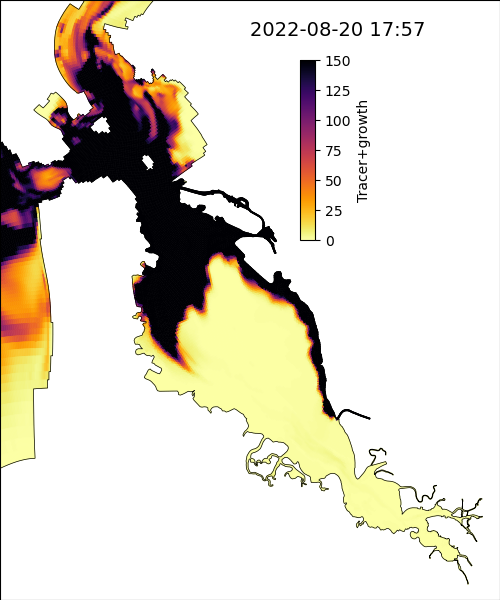

In [95]:
# Now include exponential growth
fig_dir=os.path.join(roto_dir,"blob_frames_v0growth")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
cmap=cm.inferno_r
from matplotlib import colors

zoom=(538674.1459696215, 594972.1493948983, 4138849.1773065855, 4203189.752649758)
fig,ax=plt.subplots(figsize=(5,6))
ax.set_adjustable('datalim')
cax=fig.add_axes([0.6,0.60,0.03,0.3])
fig.subplots_adjust(left=0,right=1,top=1, bottom=0)

tidxs=range(0,map_ds.dims['time'],100)
tracers=['oakland0','eastshore0','oakland1','eastshore1']
growth_rates=[0.2,0.25,0.3,0.4,0.5]

tidxs=[1535] # grab 8/20 around time of RS data

# DEV
# tracers=['oakland0']
# tidxs=[1500]

#clim=[1e-3,1]
#norm=colors.LogNorm(vmin=clim[0],vmax=clim[1])

clim=[0,150]
norm=colors.Normalize(vmin=clim[0],vmax=clim[1])
C0=50

for growth_rate in growth_rates:
    for tracer in tracers:
        for frame,tidx in enumerate(tidxs):
            frame=tidx # 
            ax.cla()
            cax.cla()
            snap=map_ds.isel(time=tidx,laydim=-1)
            scal=C0*snap[tracer].values/100.0

            t_days=(snap.time.values - map_ds.time.values[0])/np.timedelta64(86400,'s')
            growth=np.exp(growth_rate*t_days)
            scal=scal*growth
            
            coll=map_ds.grid.plot_cells(values=scal.clip(clim[0],clim[1]),
                                        cmap=cmap,clim=clim,lw=0.5,
                                        edgecolor='face',ax=ax,
                                        norm=norm)
            plt.colorbar(coll,cax=cax,label="Tracer+growth")
            plot_wkb.plot_wkb(shore_poly,fc='none',ec='k',lw=0.5,ax=ax,zorder=4)
            t_str=snap.time.dt.strftime("%Y-%m-%d %H:%M").item()
            ax.text(0.5,0.94,t_str,transform=ax.transAxes,fontsize=14)
            ax.axis(zoom)
            t_str=snap.time.dt.strftime("%Y%m%dT%H%M").item()
            img_fn=os.path.join(fig_dir,f"blob_{tracer}_k{growth_rate:0.02f}_{t_str}.png")
            fig.savefig(img_fn)


In [94]:
img_fn

'rotodfm_v05/blob_frames_v0growth/blob_eastshore1_k0.50_20220820T1757.png'

In [72]:
colors.Normalize

matplotlib.colors.Normalize

In [ ]:



ma

























In [28]:
ax.axis()

(538674.1459696215, 594972.1493948983, 4138849.1773065855, 4203189.752649758)

In [ ]:
fig,ax=plt.subplots()